In [1]:
import sys
sys.path.append('../src')
from data import train_and_testloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad('../data/opc.h5ad')

In [3]:
X = adata.X[:,:].toarray()

Calculating PHATE...
  Running PHATE on 11958 observations and 180 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 26.36 seconds.
    Calculating affinities...
    Calculated affinities in 9.70 seconds.
  Calculated graph and diffusion operator in 36.70 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.74 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.56 seconds.
  Calculated landmark operator in 10.61 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculated optimal t in 6.15 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.20 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.38 seconds.
Calculated PHATE in 60.05 seconds.


/tmp/ipykernel_2312275/2038756737.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) scatter2d. (Use scprep.plot.scatter2d instead) -- Deprecated since version 1.0.0.
  phate.plot.scatter2d(phate_coords)


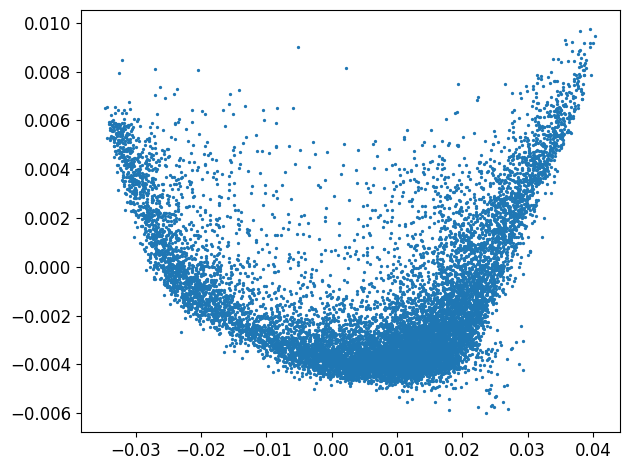

In [4]:
phate_op = phate.PHATE(random_state=42) #n_components = 2, decay=phate_decay, knn=self.n_neighbors
phate_coords = phate_op.fit_transform(X)
phate.plot.scatter2d(phate_coords)
phate_coordst = torch.tensor(phate_coords)
phate_D = torch.cdist(phate_coordst, phate_coordst).cpu().detach().numpy()

In [5]:
# op = HeatGeo(
#     knn=5,
#     tau=0.5,
#     harnack_regul=0.5,
#     denoising=True,
#     denoise_regul=0.5,
# )
# X_heatgeo = op.fit_transform(X)
# op.metric_computation(X)

In [7]:
# phate.plot.scatter2d(X_heatgeo)

In [8]:
trainloader, testloader = train_and_testloader_from_pc(
    X, # <---- Pointcloud
    phate_D, # <---- Distance matrix to match
    batch_size=64)
train_sample = next(iter(trainloader))

max_epochs = 50
model = AEDist(
    dim=train_sample['x'].shape[1],
    emb_dim=2,
    log_dist=True,
)
early_stopping = EarlyStopping('val_loss', patience=500)
trainer = Trainer(
    max_epochs=max_epochs, 
    accelerator='cuda',
    callbacks=[early_stopping],
    log_every_n_steps=50,
)

trainer.fit(
    model=model,
    train_dataloaders=trainloader,
    val_dataloaders=testloader,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/notebooks/lightning_logs/version_16249683/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Na

Sanity Checking: 0it [00:00, ?it/s]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we f

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
X_tensor = torch.from_numpy(X).float()
emb_z = model(X_tensor)[1].cpu().detach().numpy()
phate.plot.scatter2d(emb_z)

In [ ]:
pc_s, z, disparity = procrustes(phate_coords, emb_z)

In [ ]:
plt.scatter(z[:,0], z[:,1], c=phate_coords[:,1], cmap='viridis')

In [ ]:
print(disparity)

In [ ]:
torch.nn.functional.mse_loss(torch.from_numpy(pc_s), torch.from_numpy(z))